# k-NN


In this demo we're going to see the k-Nearest Neighbours algorithm, a non-linear distance-based ML model, and we'll see both its regressor and classifier variants.


In [221]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier

Let's say we want to predict the daily price movements of Apple stock. The target is 1-day returns for regression and the direction of 1-day returns for classification. For features we'll engineer some features like lagged returns and technical indicators from historical data.  
Obviously this is an extremely simplistic model and probably won't perform better than chance but our main aim here is to demonstrate how k-NN works.


In [222]:
data = yf.download("AAPL", start="2004-01-01", end="2024-01-01")
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-02,0.384821,0.388393,0.378214,0.380000,0.320901,144642400
2004-01-05,0.382500,0.399821,0.382500,0.395893,0.334322,395018400
2004-01-06,0.397321,0.400357,0.387679,0.394464,0.333115,509348000
2004-01-07,0.394643,0.407679,0.391607,0.403393,0.340655,586874400
2004-01-08,0.407857,0.423750,0.404464,0.417143,0.352267,460303200
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.868149,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.320221,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.419830,48087700


The columns are multiindex (see how they have two "levels"). I'll make `Date` a regular columna and then flatten the dataframe by resetting the index.


In [223]:
data["Date"] = data.index
data.reset_index(drop=True, inplace=True)

In [224]:
data

,Open,High,Low,Close,Adj Close,Volume,Date
0,0.384821,0.388393,0.378214,0.380000,0.320901,144642400,2004-01-02
1,0.382500,0.399821,0.382500,0.395893,0.334322,395018400,2004-01-05
2,0.397321,0.400357,0.387679,0.394464,0.333115,509348000,2004-01-06
3,0.394643,0.407679,0.391607,0.403393,0.340655,586874400,2004-01-07
4,0.407857,0.423750,0.404464,0.417143,0.352267,460303200,2004-01-08
...,...,...,...,...,...,...,...
5028,195.179993,195.410004,192.970001,193.600006,192.868149,37122800,2023-12-22
5029,193.610001,193.889999,192.830002,193.050003,192.320221,28919300,2023-12-26
5030,192.490005,193.500000,191.089996,193.149994,192.419830,48087700,2023-12-27
5031,194.139999,194.660004,193.169998,193.580002,192.848206,34049900,2023-12-28


Let's engineer some features...


In [225]:
# Engineer feature: 1-day lagged returns
data["1d_Prev_Adj_Close"] = data["Adj Close"].shift(1)
data["1d_Lagged_Return"] = (data["Adj Close"] - data["1d_Prev_Adj_Close"]) / data[
    "1d_Prev_Adj_Close"
]

# Engineer feature: 5-day lagged returns
data["5d_Prev_Adj_Close"] = data["Adj Close"].shift(5)
data["5d_Lagged_Return"] = (data["Adj Close"] - data["5d_Prev_Adj_Close"]) / data[
    "5d_Prev_Adj_Close"
]

# Engineer feature: 20-day lagged returns
data["20d_Prev_Adj_Close"] = data["Adj Close"].shift(20)
data["20d_Lagged_Return"] = (data["Adj Close"] - data["20d_Prev_Adj_Close"]) / data[
    "20d_Prev_Adj_Close"
]


# Engineer feature: RSI
def calculate_rsi(data, window_length):
    delta = data["Adj Close"].diff()
    avg_gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
    avg_loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))


data["RSI"] = calculate_rsi(data, 14)

Let's create our numerical target for regression and categorical "Up/Down" target for classification. Again, this is too simplistic and you wouldn't want to trade on the signals generated by such a model. This is all just for illustrating k-NNs.


In [226]:
# Engineer target for regression: 1-day future returns
data["1d_Future_Adj_Close"] = data["Adj Close"].shift(-1)
data["1d_Future_Return"] = (data["1d_Future_Adj_Close"] - data["Adj Close"]) / data["Adj Close"]

# Engineer target for classification: whether or not the 1-day future return is positive
data["1d_Future_Return_Positive"] = (data["1d_Future_Return"] > 0).astype(int)

# These will have created some NaNs, so let's get rid of those
data = data.dropna()

Save this data for future demos.


In [227]:
data.to_csv("AAPL.csv", index=False)

And specify our feature and target columns.


In [228]:
X = data[["1d_Lagged_Return", "5d_Lagged_Return", "20d_Lagged_Return", "RSI"]]
y_reg = data["1d_Future_Return"]
y_clf = data["1d_Future_Return_Positive"]

Split the data into training and test sets... Let's say 80-20.


In [229]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42, shuffle=False
)
_, _, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, shuffle=False
)
X_train.shape, X_test.shape, y_train_reg.shape, y_test_reg.shape, y_train_clf.shape, y_test_clf.shape

((4009, 4), (1003, 4), (4009,), (1003,), (4009,), (1003,))

**Remember:** k-NN is a distance-based algorithm so it's imperative that we scale our features, and we always do so after the split.


In [230]:
# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Now before we continue, let's take a quick look at our target variables...


In [231]:
# Establish a baseline for the regression task
print(
    f"Average return (train): {100*np.mean(y_train_reg):.2f}%\nAverage return (test): {100*np.mean(y_test_reg):.2f}%"
)

Average return (train): 0.16%
Average return (test): 0.12%


In [232]:
# Establish a baseline for the classification task
print(
    f"Percentage of UP (train): {100*np.mean(y_train_clf):.2f}%\nPercentage of UP (test): {100*np.mean(y_test_clf):.2f}%"
)

Percentage of UP (train): 53.26%
Percentage of UP (test): 52.54%


We're ready to train a model with this data.


In [309]:
k = 5

In [310]:
knn_reg = KNeighborsRegressor(n_neighbors=k)
knn_reg.fit(X_train, y_train_reg)

KNeighborsRegressor()

In [311]:
knn_clf = KNeighborsClassifier(n_neighbors=k)
knn_clf.fit(X_train, y_train_clf)

KNeighborsClassifier()

Let's take a look at the cross-validated scores and learning curves...


In [312]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, accuracy_score

In [313]:
cv_scores_reg = cross_val_score(knn_reg, X_train, y_train_reg, cv=5, scoring="r2")
mean_cv_score_reg = np.mean(cv_scores_reg)
print(f"Cross-Validated R-Squared: {mean_cv_score_reg:.4f}")

y_pred_reg = knn_reg.predict(X_test)
test_score_reg = r2_score(y_test_reg, y_pred_reg)
print(f"Test R-Squared: {test_score_reg:.4f}")

Cross-Validated R-Squared: -0.2364
Test R-Squared: -0.1619


In [314]:
cv_scores_clf = cross_val_score(knn_clf, X_train, y_train_clf, cv=5, scoring="accuracy")
mean_cv_score_clf = np.mean(cv_scores_clf)
print(f"Cross-Validated Accuracy: {mean_cv_score_clf:.2f}")

y_pred_clf = knn_clf.predict(X_test)
test_score_clf = accuracy_score(y_test_clf, y_pred_clf)
print(f"Test Accuracy: {test_score_clf:.2f}")

Cross-Validated Accuracy: 0.52
Test Accuracy: 0.51


Although the focus of this demo is k-NN models, I'd like to show you an example of how we can plot learning curves with scikit-learn and matplotlib. Let's draw the learning curves for both models...


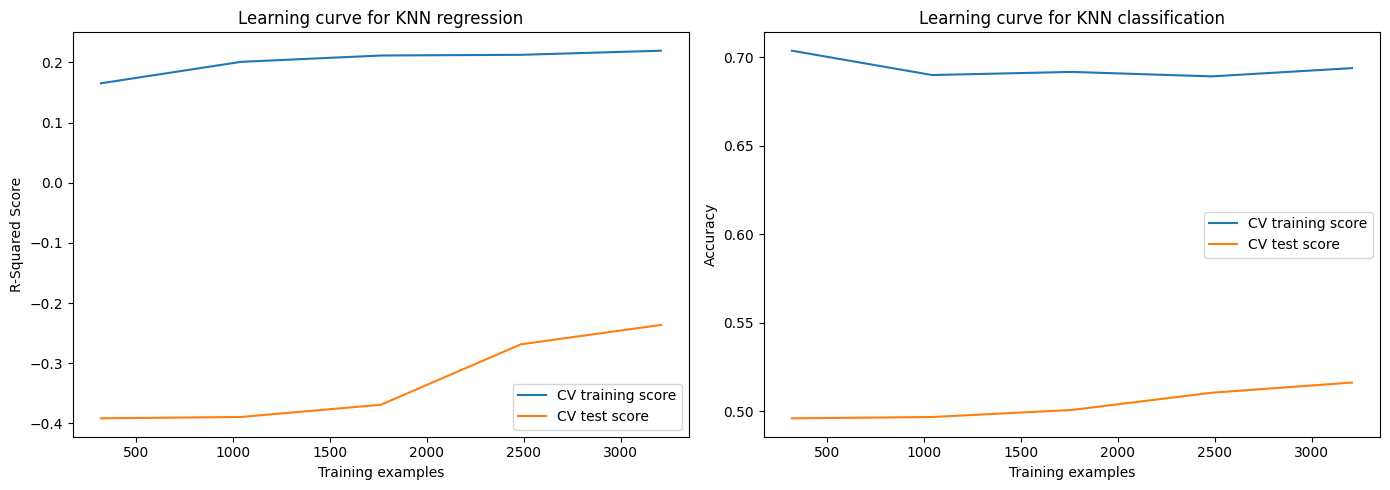

In [315]:
from sklearn.model_selection import learning_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Learning curves for the regression model
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(
    knn_reg,
    X_train,
    y_train_reg,
    cv=5,
    scoring="r2",
)
train_scores_mean = np.mean(train_scores_reg, axis=1)
test_scores_mean = np.mean(test_scores_reg, axis=1)
axes[0].plot(train_sizes_reg, train_scores_mean, label="CV training score")
axes[0].plot(train_sizes_reg, test_scores_mean, label="CV test score")
axes[0].set_title("Learning curve for KNN regression")
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("R-Squared Score")
axes[0].legend()

# Learning curves for the classification model
train_sizes_clf, train_scores_clf, test_scores_clf = learning_curve(
    knn_clf,
    X_train,
    y_train_clf,
    cv=5,
    scoring="accuracy",
)
train_scores_mean_clf = np.mean(train_scores_clf, axis=1)
test_scores_mean_clf = np.mean(test_scores_clf, axis=1)
axes[1].plot(train_sizes_clf, train_scores_mean_clf, label="CV training score")
axes[1].plot(train_sizes_clf, test_scores_mean_clf, label="CV test score")
axes[1].set_title("Learning curve for KNN classification")
axes[1].set_xlabel("Training examples")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

We can see the dynamics we talked about with the classifier model on the right. Training scores get worse as we train on more data and at the same time validation scores get better. But they're not really converging much and a CV accuracy score of 52% is most likely not much better than tossing a coin, or always predicting up, for example.  
Now you might be asking why those r-squared numbers for the cross-validation score on the left are negative! After all it's called R-_squared_. Shouldn't it be always positive? And indeed it would have been if our regression model performed better than a naive baseline model that always predicts the average. So as counterintuitive as a negative R-squared score can be, it's actually easy to interpret: It just means it's performing even worse than a model that alwas predicts the mean. Here, both the training and validation R-squared scores are negative which means the model is massively underfitting.  
Normally in reality we don't use regression models for predicting price movements like this because we don't care about the actual percentage return as that is next to impossible to predict. There's not enough signal in all the noise. For that reason, classifer models are more common for this purpose.


Let's see what effects increasing and decreasing the number of neighbours _k_ has on the outcome.
